<a href="https://colab.research.google.com/github/Maziger/master-reinforcement-learning/blob/main/Notebooks/Project03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Instructions

This notebook contains the third project assignment. You work on the project in groups. You should already have formed a group. If not, do it on Brightspace under *My Courses > Groups*. To get started, do the following steps:

1) One student in the group makes a copy of this notebook.
2) Share it with your group using *Share* top-right. Here, add group members under people with access.
3) Moreover, under *Share > General access*, choose *Anyone with the link > Commenter*. Copy this link and paste it below.
4) Work with the notebook and solve the tasks.
5) Hand in the notebook by downloading it: File > Download > Download .ipynb. Next, on BS under *Project*, upload the file (I need that for the exam). Moreover, add the shared link of your Colab notebook as a link when you handin too.
6) After hand-in do peer grading (see BS under *Project*)

Sharing link: https://colab.research.google.com/drive/1PRaVnhYL1ELaXfEXdsvQSRiOIQXNqQsF?usp=sharing

**Deadlines**

* Hand-in solution 7/12/25
* Peer grading 13/12/25


# Notebook pre steps

In [1]:
#@title Installations

# install missing packages
!pip install -q dfply

import numpy as np
import gdown
import gzip
import pandas as pd
import itertools
import joblib
import warnings
from dfply import *
from IPython.display import Markdown
from plotnine import *
from pprint import pprint
from scipy.stats import norm
from tqdm import tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.4/612.4 kB 8.6 MB/s eta 0:00:00


# Problem description

Consider the [Hour-to-hour electricity market problem](https://colab.research.google.com/drive/1BFI6iRLTnrHgxgFayC89SKhuM3XcIp7s?usp=sharing) that we solved using a Markov decision process by discretising the state and action space.

Here, we are going to solve the problem using RL with approximation. How to solve the problem depends on which environment your are using. You may use one of the following environment for the problem:

1. The environment given in [Project 2](https://colab.research.google.com/drive/1HhQbV2ZvfMsEv-RkoGS6Sj0mjzC9QYF8?usp=sharing) which uses a discretization of both states and actions,
2. The environment given in the section "Environment with discrete actions" below.
3. The environment given in the section "Environment with continuous actions" below.

In all environments we represent state and actions using tuples $s_t = (s^l_t,s^c_t,s^w_t,s^p_t)$ and $a_t = (a^b_t, a^w_t, a^c_t)$. Moreover, we use settings:

# Environment with discrete actions

We here use an environment where

1. The battery only can be charged/discharged in units of $\delta$, e.g. $\delta = 1$ MWh. That is, $a^b_t \in \{-b^{\max}, \ldots, -\delta, 0, \delta, ..., b^{\max} \}$
2. Due to 1, the battery level is $s^l_t \in \{ 0, \delta, 2\delta, ..., b^{\max} \}$.
3. The same units are used for the wind energy production $a^w_t \in \{ 0, \delta, 2\delta, ..., p^{\max} \}$.
4. Due to 1-3, the commitment levels are $s^c_t \in \{ -b^\max, \ldots, -\delta, 0, \delta, \ldots, b^{\max} + p^{\max}\}$ since we can at most buy energy for an empty battery and we can at most sell max wind production plus a full battery. That is, $a^c_t$ have these commitment levels.

Note $\delta$ must satisfy that $b^{\max}/\delta$ and $p^{\max}/\delta$ are integer. Moreover, when calculating $E(x)$, its value must be rounded down so contained in the set defined for $a^w_t$.

To specify the discrete actions we only need to specify sets for the wind and commitment levels. Hence the battery levels will automatically be discrete too.

The environment is implemented below.


In [2]:
class EnvEnergyDiscrete:
    """
    Environment for the hour-to-hour electricity market problem with discrete actions.
    """

    def __init__(self, settings, a_w_tuple, a_c_tuple, seed = 25328):
        """
        Initialize the environment.

        Args:
            settings (dict): A dictionary containing problem settings
            a_w_tuple (list): A list of possible wind usage
            a_c_tuple (list): A list of possible commitment levels


            seed (int): A seed for the random number generator
        """
        self.settings = settings

        ## price model
        # Google Drive direct download URL (using the 'uc?id=' format)
        url = 'https://drive.google.com/uc?id=1cGhte06iiWZnaRLPyj5D8ZzWX7gqPsIR'
        # Output filename for the downloaded file
        output_filename = 'prices_ar1.pkl.gz'
        # Download the file from Google Drive
        gdown.download(url, output_filename, quiet=True)
        # Load the model from the downloaded file
        with gzip.open(output_filename, "rb") as f:
            model_price = joblib.load(f)
        print(f"Price model loaded successfully from {output_filename}")
        self.model_price = model_price

        ## wind model
        # Google Drive direct download URL (using the 'uc?id=' format)
        url = 'https://drive.google.com/uc?id=1TJ1ACzev40QbeUlXBbDicYU3kEyiH1nB'
        # Output filename for the downloaded file
        output_filename = 'wind_log_ar1.pkl.gz'
        # Download the file from Google Drive
        gdown.download(url, output_filename, quiet=True)
        # Load the model from the downloaded file
        with gzip.open(output_filename, "rb") as f:
            model_wind = joblib.load(f)
        print(f"Wind model loaded successfully from {output_filename}")
        self.model_wind = model_wind

        self.rng = np.random.default_rng(seed)

        self.a_c_tuple = a_c_tuple
        self.a_w_tuple = a_w_tuple

    def reset_rng(self, seed):
        """
        Reset the random number generator.

        Args:
            seed (int): A seed for the random number generator
        """
        self.rng = np.random.default_rng(seed)

    def get_left(self, sorted_list, a):
        """
        Given a sorted list and a number 'a', finds the largest number 'b' in
        the list so b <= a

        Args:
            sorted_list (list): A list of numbers sorted in ascending order.
            a (float or int): The number to find the bounds for.

        Returns:
            float or int: The largest number 'b' in the list so b <= a.
        """
        # Iterate through the sorted list to find the bounds
        for i in range(len(sorted_list)-1, -1, -1):
            if sorted_list[i] <= a:
                return sorted_list[i]
        return None

    def get_actions(self, s: tuple) -> list:
        """
        Get all possible actions for a given state.
        """
        s_l, s_c, s_w, _ = s
        b_max = self.settings['b_max']
        # Determine a_b and a_w
        e_max = self.get_left(self.a_w_tuple, self.energy(s_w)) # max energy we can sell/produce (e.g. if energy(s_w) = 1.25 but a_w_tuple is [0,1,2,...] then can only sell 1)
        if s_c >= 0:
            if s_c >= e_max:
                a_b = min(s_l, s_c - e_max)
                a_w = e_max
            else: # s_c < e_max:
                a_b = -min(b_max - s_l, e_max - s_c)
                a_w = s_c - a_b
        else: # s_c < 0:
            a_b = -min(b_max - s_l, - s_c + e_max)
            a_w = max(0, - a_b + s_c)

        actions = [(float(a_b), float(a_w), float(a_c)) for a_c in self.a_c_tuple if a_c >= -(b_max - (s_l - a_b))]
        # if -(b_max - (s_l - a_b)) > -10:
        #     print(f"s_c: {s_c},  s_w: {s_w}, e_max: {e_max}")
        #     print(f"s_l: {s_l}, a_b: {a_b}, a_w: {a_w}, min a_c: {-(b_max - (s_l - a_b))}")
        #     print(min([a[2] for a in actions]))
        return actions

    def state_variables_to_str(self, s_l, s_c, s_w, s_p):
        """
        String representaion of a state.
        """
        return "{'s_l': " + str(s_l) + ", 's_c': " + str(s_c) + ", 's_w': " + str(s_w) + ", 's_p': " + str(s_p) + "}"

    def action_variables_to_str(self, a_b, a_w, a_c):
        """
        String representaion of an action.
        """
        return "{'a_b': " + str(a_b) + ", 'a_w': " + str(a_w) + ", 'a_c': " + str(a_c) + "}"

    def power(self, wind_speed):
        """
        The power output of a wind turbine given a wind speed.
        """
        p_max = self.settings['p_max']
        w_cut_in = self.settings['w_cut_in']
        w_rated = self.settings['w_rated']
        w_cut_out = self.settings['w_cut_out']

        if wind_speed < w_cut_in:
            return 0
        elif w_cut_in <= wind_speed <= w_rated:
            return p_max * ((wind_speed - w_cut_in) / (w_rated - w_cut_in)) ** 3
        elif w_rated < wind_speed <= w_cut_out:
            return p_max
        else:
            return 0

    def energy(self, w, time_period_length = 1):
        """
        The energy output of a wind turbine over one hour given a wind speed (MWh).
        """
        return self.power(w) * time_period_length

    def energy_inverse(self, energy_target, time_period_length = 1):
        """
        Find the wind speed that produces a given amount of energy, assuming wind is between w_cut_in and w_rated.

        Args:
            energy_target (float): The target energy output in MWh.
            time_period_length (float, optional): The time period length in hours. Defaults to 1.

        Returns:
            float: The wind speed that produces the given energy.
        """
        p_max = self.settings['p_max']
        w_cut_in = self.settings['w_cut_in']
        w_rated = self.settings['w_rated']

        if energy_target < 0 or energy_target > p_max:
            return None

        def find_wind_speed(w):
            return self.energy(w, time_period_length) - energy_target

        sol = root_scalar(find_wind_speed, bracket=[w_cut_in, w_rated], method='brentq')
        return sol.root if sol.converged else None


    def get_reward(self, s_p, s_c, a_b, a_w):
        """
        Calculate the reward for given state-action values.
        """
        c_plus = self.settings['c_plus']
        c_minus = self.settings['c_minus']
        e = a_b + a_w
        if s_p >= 0:
            return s_c * s_p - c_plus * abs(s_c - e)
        if s_p < 0:
            return s_c * s_p - c_minus * abs(s_c - e)
        raise ValueError("Reward can not be calculated.")

    def generate_price_next_hour(self, price):
        """
        Generates a random sample of the price for the next hour based on an AR(1) model.

        Args:
            price (float): The current price.

        Returns:
            float: A random sample of the next hour's price.
        """
        phi = self.model_price.params.iloc[1]
        intercept = self.model_price.params.iloc[0]
        sigma = self.model_price.resid.std()
        # The mean of the next price's distribution is the predicted value
        mean_next_price = intercept + phi * price
        # The standard deviation of the next price's distribution is the residual standard deviation
        std_dev_next_price = sigma
        # Generate a random sample from a normal distribution
        price_next_sample = self.rng.normal(loc=mean_next_price, scale=std_dev_next_price)
        return price_next_sample

    def generate_wind_next_hour(self, wind):
        """
        Generates a random sample of the wind speed for the next hour based on an AR(1) model.

        Args:
            wind (float): The current wind speed.

        Returns:
            float: A random sample of the next hour's wind speed.
        """
        # Add a small epsilon to prevent log(0) if wind is zero.
        # This ensures numerical stability for the log-transformed AR(1) model.
        min_positive_wind = 1e-6 # A very small positive number to avoid log(0)
        log_wind = np.log(max(wind, min_positive_wind))
        phi = self.model_wind.params.iloc[1]
        intercept = self.model_wind.params.iloc[0]
        sigma = self.model_wind.resid.std()
        # The mean of the next wind speed's distribution is the predicted value
        log_mean_next_wind = intercept + phi * log_wind
        # The standard deviation of the next wind speed's distribution is the residual standard deviation
        std_dev_next_wind = sigma
        # Generate a random sample from a normal distribution
        log_wind_next_sample = self.rng.normal(loc=log_mean_next_wind, scale=std_dev_next_wind)
        return np.exp(log_wind_next_sample)

    def get_step(self, s: tuple, a: tuple):
        """
        Compute one-step transition and reward from (s, a).

        Args:
            s: State label
            a: Action label

        Returns:
            tuple: (sN, r)
        """
        s_l, s_c, s_w, s_p = s
        a_b, a_w, a_c = a
        s_l_next = float(s_l - a_b)
        s_c_next = float(a_c)
        s_w_next = float(self.generate_wind_next_hour(s_w)) # update current values
        s_p_next = float(self.generate_price_next_hour(s_p))
        s_next = [s_l_next, s_c_next, s_w_next, s_p_next]
        reward = float(self.get_reward(s_p, s_c, a_b, a_w))
        return s_next, reward


Let us create an instance of the class:

In [3]:
def generate_discrete_set(min_val, max_val, step):
    """
    Generates a set of discrete values from min_val to max_val with step size.

    Args:
        min_val (float): The minimum value in the set.
        max_val (float): The maximum value in the set.
        step (float): The step size between consecutive values.

    Returns:
        set: A set of discrete values {min_val,…,−𝛿,0,𝛿,...,max_val}.
    """
    # Ensure step is a divisor of min_val
    if not np.isclose(min_val % step, 0):
        raise ValueError("min_val argument must be divisible by step.")
    if not np.isclose(max_val % step, 0):
        raise ValueError("max_val argument must be divisible by step.")
    return np.arange(min_val, max_val + step, step)

# These settings could be changed (not in original code)
settings = {
    'b_max': 10,  # battery capacity (MWh)
    'p_max': 10,  # max power output wind (MW)
    'c_max': 10 + 10,  # max commitment (MWh) # b_max + p_max
    'w_cut_in': 3,  # cut in wind speed (m/s)
    'w_rated': 12,  # rated wind speed (m/s)
    'w_cut_out': 25,  # cut out wind speed (m/s)
    'c_plus': 50,  # EUR/MWh
    'c_minus': 50, # EUR/MWh
}

step_mwh = 2
b_max = settings['b_max']
p_max = settings['p_max']
c_max = settings['c_max']
a_w_tuple = generate_discrete_set(0, p_max, step_mwh)
a_c_tuple = generate_discrete_set(-b_max, c_max, step_mwh)

envD = EnvEnergyDiscrete(settings, a_w_tuple = a_w_tuple, a_c_tuple = a_c_tuple)

Price model loaded successfully from prices_ar1.pkl.gz
Wind model loaded successfully from wind_log_ar1.pkl.gz


## Q1

Consider the code below and explain the output.

In [4]:
#@title Solution

import random

s = [4.0, 6.0, 12.4, 34.7] #  s = (s_l, s_c, s_w, s_p)
np.random.seed(0)
for _ in range(5):
    actions = envD.get_actions(s)  # a = (a_b, a_w, a_c)
    a = random.choice(actions)
    print(f"(s_l, s_c, s_w, s_p): {s}, (a_b, a_w, a_c): {a} ->", end = " ")
    s, r = envD.get_step(s, a)
    s = [round(v,1) for v in s]
    a = [round(v,0) for v in a]
    print(f"{s}, Rew: {r:1.1f}")


(s_l, s_c, s_w, s_p): [4.0, 6.0, 12.4, 34.7], (a_b, a_w, a_c): (-4.0, 10.0, 14.0) -> [8.0, 14.0, 28.0, 41.7], Rew: 208.2
(s_l, s_c, s_w, s_p): [8.0, 14.0, 28.0, 41.7], (a_b, a_w, a_c): (8.0, 0.0, 8.0) -> [0.0, 8.0, 32.4, 44.8], Rew: 283.8
(s_l, s_c, s_w, s_p): [0.0, 8.0, 32.4, 44.8], (a_b, a_w, a_c): (0.0, 0.0, 14.0) -> [0.0, 14.0, 52.6, 47.9], Rew: -41.6
(s_l, s_c, s_w, s_p): [0.0, 14.0, 52.6, 47.9], (a_b, a_w, a_c): (0.0, 0.0, 14.0) -> [0.0, 14.0, 116.1, 52.0], Rew: -29.4
(s_l, s_c, s_w, s_p): [0.0, 14.0, 116.1, 52.0], (a_b, a_w, a_c): (0.0, 0.0, 8.0) -> [0.0, 8.0, 11.8, 60.6], Rew: 28.0


In [5]:
display(Markdown("""
We start in the state where we have 4.0 MWh in battery, and the commitment levels
is 6 MW. The wind speed is 12.4 m/s and price 34.7. We then choose a random
action among the possible actions, and print. We obseve the reward and the
next state, which is printed. We observe a reward of 208, as this is the power
we sell $6 * 34.7 = 208.2$. This is repeated 5 times.

The next state we have a commitment of 20, as this was the commitment action
chosen in the previous period. It then chooses another commitment level at
random (10MW), and we observe the reward again. This is a low reward, as we have
a big imbalance, as we have a big imablance (commiting 8 when we have commited 20).
This continues for 5 iterations.

We do not generate wind energy in the third iteration, as it is above the
w_cut_out limit.
"""))


We start in the state where we have 4.0 MWh in battery, and the commitment levels
is 6 MW. The wind speed is 12.4 m/s and price 34.7. We then choose a random
action among the possible actions, and print. We obseve the reward and the
next state, which is printed. We observe a reward of 208, as this is the power
we sell $6 * 34.7 = 208.2$. This is repeated 5 times.

The next state we have a commitment of 20, as this was the commitment action
chosen in the previous period. It then chooses another commitment level at
random (10MW), and we observe the reward again. This is a low reward, as we have
a big imbalance, as we have a big imablance (commiting 8 when we have commited 20).
This continues for 5 iterations.

We do not generate wind energy in the third iteration, as it is above the
w_cut_out limit.


# Environment with continuous actions

We here use an environment where both actions and states are continuous.

The environment is implemented below.


In [6]:
class EnvEnergyCont:
    """
    Environment for the hour-to-hour electricity market problem with continuous actions.
    """

    def __init__(self, settings, seed = 25328):
        """
        Initialize the environment.

        Args:
            settings (dict): A dictionary containing problem settings
            seed (int): A seed for the random number generator
        """
        self.settings = settings

        ## price model
        # Google Drive direct download URL (using the 'uc?id=' format)
        url = 'https://drive.google.com/uc?id=1cGhte06iiWZnaRLPyj5D8ZzWX7gqPsIR'
        # Output filename for the downloaded file
        output_filename = 'prices_ar1.pkl.gz'
        # Download the file from Google Drive
        gdown.download(url, output_filename, quiet=True)
        # Load the model from the downloaded file
        with gzip.open(output_filename, "rb") as f:
            model_price = joblib.load(f)
        print(f"Price model loaded successfully from {output_filename}")
        self.model_price = model_price

        ## wind model
        # Google Drive direct download URL (using the 'uc?id=' format)
        url = 'https://drive.google.com/uc?id=1TJ1ACzev40QbeUlXBbDicYU3kEyiH1nB'
        # Output filename for the downloaded file
        output_filename = 'wind_log_ar1.pkl.gz'
        # Download the file from Google Drive
        gdown.download(url, output_filename, quiet=True)
        # Load the model from the downloaded file
        with gzip.open(output_filename, "rb") as f:
            model_wind = joblib.load(f)
        print(f"Wind model loaded successfully from {output_filename}")
        self.model_wind = model_wind

        self.rng = np.random.default_rng(seed)

    def reset_rng(self, seed):
        """
        Reset the random number generator.

        Args:
            seed (int): A seed for the random number generator
        """
        self.rng = np.random.default_rng(seed)

    def check_s(self, s):
        """
        Check if a state is valid.
        """
        s_l, s_c, s_w, _ = s
        assert s_l >= 0 and s_l <= self.settings['b_max']
        assert s_c >= -self.settings['b_max'] and s_c <= self.settings['c_max']
        assert s_w >= 0

    def check_a(self, a):
        """
        Check if an action is valid.
        """
        a_b, a_w, a_c = a
        assert a_b >= -self.settings['b_max'] and a_b <= self.settings['b_max']
        assert a_w >= 0
        assert a_c >= -self.settings['b_max'] and a_c <= self.settings['c_max']

    def get_action_info(self, s: tuple) -> tuple:
        """
        Get fixed actions for a given state and the minimum a_c value to choose.
        """
        self.check_s(s)
        s_l, s_c, s_w, _ = s
        b_max = self.settings['b_max']
        # Determine a_b and a_w
        e_max = self.energy(s_w) # max wind energy we can sell/produce
        if s_c >= 0:
            if s_c >= e_max:
                a_b = min(s_l, s_c - e_max)
                a_w = e_max
            else: # s_c < e_max:
                a_b = -min(b_max - s_l, e_max - s_c)
                a_w = s_c - a_b
        else: # s_c < 0:
            a_b = -min(b_max - s_l, - s_c + e_max)
            a_w = max(0, - a_b + s_c)
        # print(f"s_c: {s_c},  s_w: {s_w}, e_max: {e_max}")
        # print(f"s_l: {s_l}, a_b: {a_b}, a_w: {a_w}, min a_c: {-(b_max - (s_l - a_b))}")
        a_c_min = -(b_max - (s_l - a_b))  # no need to buy power that cannot be stored
        return float(a_b), float(a_w), float(a_c_min)

    def state_variables_to_str(self, s_l, s_c, s_w, s_p):
        """
        String representaion of a state.
        """
        return "{'s_l': " + str(s_l) + ", 's_c': " + str(s_c) + ", 's_w': " + str(s_w) + ", 's_p': " + str(s_p) + "}"

    def action_variables_to_str(self, a_b, a_w, a_c):
        """
        String representaion of an action.
        """
        return "{'a_b': " + str(a_b) + ", 'a_w': " + str(a_w) + ", 'a_c': " + str(a_c) + "}"

    def power(self, wind_speed):
        """
        The power output of a wind turbine given a wind speed.
        """
        p_max = self.settings['p_max']
        w_cut_in = self.settings['w_cut_in']
        w_rated = self.settings['w_rated']
        w_cut_out = self.settings['w_cut_out']

        if wind_speed < w_cut_in:
            return 0
        elif w_cut_in <= wind_speed <= w_rated:
            return p_max * ((wind_speed - w_cut_in) / (w_rated - w_cut_in)) ** 3
        elif w_rated < wind_speed <= w_cut_out:
            return p_max
        else:
            return 0

    def energy(self, w, time_period_length = 1):
        """
        The energy output of a wind turbine over one hour given a wind speed (MWh).
        """
        return self.power(w) * time_period_length

    def get_reward(self, s_p, s_c, a_b, a_w):
        """
        Calculate the reward for given state-action values.
        """
        c_plus = self.settings['c_plus']
        c_minus = self.settings['c_minus']
        e = a_b + a_w
        if s_p >= 0:
            return s_c * s_p - c_plus * abs(s_c - e)
        if s_p < 0:
            return s_c * s_p - c_minus * abs(s_c - e)
        raise ValueError("Reward can not be calculated.")

    def generate_price_next_hour(self, price):
        """
        Generates a random sample of the price for the next hour based on an AR(1) model.

        Args:
            price (float): The current price.

        Returns:
            float: A random sample of the next hour's price.
        """
        phi = self.model_price.params.iloc[1]
        intercept = self.model_price.params.iloc[0]
        sigma = self.model_price.resid.std()
        # The mean of the next price's distribution is the predicted value
        mean_next_price = intercept + phi * price
        # The standard deviation of the next price's distribution is the residual standard deviation
        std_dev_next_price = sigma
        # Generate a random sample from a normal distribution
        price_next_sample = self.rng.normal(loc=mean_next_price, scale=std_dev_next_price)
        return price_next_sample

    def generate_wind_next_hour(self, wind):
        """
        Generates a random sample of the wind speed for the next hour based on an AR(1) model.

        Args:
            wind (float): The current wind speed.

        Returns:
            float: A random sample of the next hour's wind speed.
        """
        # Add a small epsilon to prevent log(0) if wind is zero.
        # This ensures numerical stability for the log-transformed AR(1) model.
        min_positive_wind = 1e-6 # A very small positive number to avoid log(0)
        log_wind = np.log(max(wind, min_positive_wind))
        phi = self.model_wind.params.iloc[1]
        intercept = self.model_wind.params.iloc[0]
        sigma = self.model_wind.resid.std()
        # The mean of the next wind speed's distribution is the predicted value
        log_mean_next_wind = intercept + phi * log_wind
        # The standard deviation of the next wind speed's distribution is the residual standard deviation
        std_dev_next_wind = sigma
        # Generate a random sample from a normal distribution
        log_wind_next_sample = self.rng.normal(loc=log_mean_next_wind, scale=std_dev_next_wind)
        return np.exp(log_wind_next_sample)

    def get_step(self, s: tuple, a: tuple):
        """
        Compute one-step transition and reward from (s, a).

        Args:
            s: State label
            a: Action label

        Returns:
            tuple: (sN, r)
        """
        self.check_s(s)
        self.check_a(a)
        s_l, s_c, s_w, s_p = s
        a_b, a_w, a_c = a
        s_l_next = float(s_l - a_b)
        s_c_next = float(a_c)
        s_w_next = float(self.generate_wind_next_hour(s_w)) # update current values
        s_p_next = float(self.generate_price_next_hour(s_p))
        s_next = [s_l_next, s_c_next, s_w_next, s_p_next]
        self.check_s(s_next)
        reward = float(self.get_reward(s_p, s_c, a_b, a_w))
        return s_next, reward


Let us create an instance of the class:

In [7]:
envC = EnvEnergyCont(settings)

Price model loaded successfully from prices_ar1.pkl.gz
Wind model loaded successfully from wind_log_ar1.pkl.gz


## Q2

Consider the code below and explain the output.

In [8]:
#@title Solution

import random

s = [4.6, 12.7, 12.4, 34.7] #  s = (s_l, s_c, s_w, s_p)
for _ in range(5):
    a_b, a_w, a_c_min = envC.get_action_info(s)  # a = (a_b, a_w, a_c)
    a_c = random.uniform(a_c_min, c_max)
    a = (a_b, a_w, a_c)
    a = [round(v,1) for v in a]
    print(f"(s_l, s_c, s_w, s_p): {s}, (a_b, a_w, a_c): {a} ->", end = " ")
    s, r = envC.get_step(s, a)
    s = [round(v,1) for v in s]
    print(f"{s}, Rew: {r:1.1f}")

(s_l, s_c, s_w, s_p): [4.6, 12.7, 12.4, 34.7], (a_b, a_w, a_c): [2.7, 10.0, -6.5] -> [1.9, -6.5, 28.0, 41.7], Rew: 440.7
(s_l, s_c, s_w, s_p): [1.9, -6.5, 28.0, 41.7], (a_b, a_w, a_c): [-6.5, 0.0, 5.3] -> [8.4, 5.3, 32.4, 44.8], Rew: -271.1
(s_l, s_c, s_w, s_p): [8.4, 5.3, 32.4, 44.8], (a_b, a_w, a_c): [5.3, 0.0, 2.1] -> [3.1, 2.1, 52.6, 47.9], Rew: 237.4
(s_l, s_c, s_w, s_p): [3.1, 2.1, 52.6, 47.9], (a_b, a_w, a_c): [2.1, 0.0, 7.5] -> [1.0, 7.5, 116.1, 52.0], Rew: 100.6
(s_l, s_c, s_w, s_p): [1.0, 7.5, 116.1, 52.0], (a_b, a_w, a_c): [1.0, 0.0, 0.2] -> [0.0, 0.2, 11.8, 60.6], Rew: 65.0


In [9]:
display(Markdown("""
The code is very similar, but in this case we have a continuous action space,
meaning that we can choose decimal numbers for how much power we sell and buy.
We therefore choose a random decimal between the minimum possible commitment
and the maximum commitment possible. The decimal is then rounded to .1.

We start in the state with a battery level of 4.6 and a commitment of 12.7.
We then choose to sell 2.7 from the battery and 10 from the wind, which leaves
us without an imbalance, and we have a reward of $440.7. The next period
we only choose to commit 0.2, which is a low number, and we therefore only
have a small reward here. As we have excess wind energy, we charge the battery
by 8.1MW.

This is repeated 5 times, and we end in a state where we have a battery
level of 10MW, and a commitment level of 13.5MW.
"""))


The code is very similar, but in this case we have a continuous action space,
meaning that we can choose decimal numbers for how much power we sell and buy.
We therefore choose a random decimal between the minimum possible commitment
and the maximum commitment possible. The decimal is then rounded to .1.

We start in the state with a battery level of 4.6 and a commitment of 12.7.
We then choose to sell 2.7 from the battery and 10 from the wind, which leaves
us without an imbalance, and we have a reward of $440.7. The next period
we only choose to commit 0.2, which is a low number, and we therefore only
have a small reward here. As we have excess wind energy, we charge the battery
by 8.1MW.

This is repeated 5 times, and we end in a state where we have a battery
level of 10MW, and a commitment level of 13.5MW.


# Q3 - Solving the problem

Our objective is to maximise the average reward. Pick one of the environments above and solve the problem. Note in theory by having continuous actions, you don't limit your action space and you should be able to get a better objective value.

For solving the problem, you have different options:

1. Implement classes for state-value and policy approximation and apply an actor-critic algorithm, similar to what we have done in the course.
2. Convert the environment into a Gym-style RL environment so it can be used with an RL library. Then, utilise the RL library to solve the problem. Note that in most RL libraries, the objective is discounted reward, which we have argued is not the most suitable choice for continuing problems. However, if you use a discount rate close to 1 (such as 0.9999), you can mimic the average reward objective.

State and clearly connect your choices to (also holds if you use Deep RL):

* The average reward objective.
* Theory regarding state-value approximations.
* Theory about policy approximations.
* Theory used which has not been presented in the course.

ChatGPT (or similar) can be useful for initial guidance, but remember to critically evaluate and understand the reasoning behind your choices. If you require GPU acceleration in Colab, then change the runtime type to GPU-T4 (the dropdown beside RAM in the upper right corner).




In [10]:
"""
Actor-Critic Solution for Energy Trading (Q3)
Differential (average reward) formulation for continuing task
"""

import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

# ============================================================================
# Tile Coder (from notebook)
# ============================================================================

import hashlib

class TileCoder:
    def __init__(self, n_tilings, tiles_per_dim, ranges, seed=None):
        self.n_tilings = n_tilings
        self.tiles_per_dim = np.array(tiles_per_dim)
        self.ranges = np.array(ranges)
        self.d = len(ranges)

        # Deterministic offsets
        widths = 1.0 / self.tiles_per_dim
        t = np.arange(n_tilings).reshape(-1, 1)
        self.offsets = (t / n_tilings) * widths

        self.hash_size = 4096

    def _normalize(self, x):
        x = np.array(x)
        lo, hi = self.ranges[:, 0], self.ranges[:, 1]
        return np.clip((x - lo) / (hi - lo), 0, 1)

    def _hash(self, t, idxs):
        payload = np.array([t, *idxs], dtype=np.int64).tobytes()
        h = hashlib.sha256(payload).digest()
        return int.from_bytes(h[:8], 'little') % self.hash_size

    def active_indices(self, x):
        u = self._normalize(x)
        indices = []
        for t in range(self.n_tilings):
            v = u + self.offsets[t]
            idxs = tuple(min(int(np.floor(vi * tpd)), tpd-1)
                        for vi, tpd in zip(v, self.tiles_per_dim))
            indices.append(self._hash(t, idxs))
        return np.array(indices, dtype=int)

# ============================================================================
# Value Function (Tile Coding)
# ============================================================================

class ValueFunctionTileCoding:
    def __init__(self, env, step_size, n_tilings=8, tiles_per_dim=8):
        self.env = env
        self.alpha = step_size / n_tilings

        # State ranges
        ranges = [
            (0, env.settings['b_max']),           # s_l
            (-env.settings['b_max'], env.settings['c_max']),  # s_c
            (0, 30),                               # s_w
            (-50, 150)                             # s_p
        ]

        self.tc = TileCoder(n_tilings, [tiles_per_dim]*4, ranges)
        self.w = np.zeros(self.tc.hash_size)

    def eval(self, s):
        idxs = self.tc.active_indices(s)
        return float(np.sum(self.w[idxs]))

    def train(self, s, target):
        idxs = self.tc.active_indices(s)
        v_s = np.sum(self.w[idxs])
        delta = target - v_s
        self.w[idxs] += self.alpha * delta

# ============================================================================
# Policy (Softmax Tabular)
# ============================================================================

class SoftmaxPolicyTabular:
    def __init__(self, env, step_size, rng_seed=42):
        self.env = env
        self.alpha = step_size
        self.rng = np.random.default_rng(rng_seed)

        # All commitment actions
        self.actions = list(env.a_c_tuple)
        self.num_actions = len(self.actions)
        self.action_to_idx = {a: i for i, a in enumerate(self.actions)}

        # Discretize state space for tabular policy
        b_max = env.settings['b_max']
        c_max = env.settings['c_max']

        # State discretization: (s_l, s_c, s_w_bin, s_p_bin)
        self.s_l_bins = np.linspace(0, b_max, 6)  # 5 bins
        self.s_c_bins = np.linspace(-b_max, c_max, 8)  # 7 bins
        self.s_w_bins = np.array([0, 5, 10, 15, 30])  # 4 bins
        self.s_p_bins = np.array([-50, 0, 30, 60, 150])  # 4 bins

        self.n_states = 5 * 7 * 4 * 4  # Total discrete states

        # Preferences: θ[state_idx, action_idx]
        self.theta = np.zeros((self.n_states, self.num_actions))

    def _discretize_state(self, s):
        s_l, s_c, s_w, s_p = s
        i_l = np.digitize(s_l, self.s_l_bins) - 1
        i_c = np.digitize(s_c, self.s_c_bins) - 1
        i_w = np.digitize(s_w, self.s_w_bins) - 1
        i_p = np.digitize(s_p, self.s_p_bins) - 1

        # Flatten to single index
        idx = (i_l * 7 * 4 * 4 + i_c * 4 * 4 + i_w * 4 + i_p)
        return min(max(idx, 0), self.n_states - 1)

    def _softmax(self, prefs):
        c = np.max(prefs)
        exp_p = np.exp(prefs - c)
        return exp_p / np.sum(exp_p)

    def get_action(self, s):
        state_idx = self._discretize_state(s)

        # Get feasible actions
        env_actions = self.env.get_actions(s)
        feasible_a_c = [a[2] for a in env_actions]
        idxs = [self.action_to_idx[a] for a in feasible_a_c]

        # Softmax over feasible actions
        prefs = self.theta[state_idx, idxs]
        probs = self._softmax(prefs)

        chosen_idx = self.rng.choice(len(feasible_a_c), p=probs)
        return feasible_a_c[chosen_idx]

    def train(self, s, a_c, mult):
        state_idx = self._discretize_state(s)

        env_actions = self.env.get_actions(s)
        feasible_a_c = [a[2] for a in env_actions]
        idxs = np.array([self.action_to_idx[a] for a in feasible_a_c])

        prefs = self.theta[state_idx, idxs]
        probs = self._softmax(prefs)

        # Gradient
        j_taken = feasible_a_c.index(a_c)
        grad = -probs.copy()
        grad[j_taken] += 1.0

        # Update
        self.theta[state_idx, idxs] += self.alpha * mult * grad

# ============================================================================
# Actor-Critic Algorithm
# ============================================================================

def actor_critic_continuing(pi_hat, v_hat, env, steps, alpha_r=0.001):
    # Initialize
    s = [5.0, 5.0, 10.0, 40.0]  # s_l, s_c, s_w, s_p
    r_bar = 0.0

    rewards = []
    r_bar_history = []

    print(f"Training for {steps} steps...")
    for t in tqdm(range(1, steps + 1)):
        # Sample action from policy
        a_c = pi_hat.get_action(s)

        # Get full action tuple
        env_actions = env.get_actions(s)
        a = next((a for a in env_actions if a[2] == a_c), env_actions[0])

        # Take step
        s_next, r = env.get_step(s, a)

        # TD error (differential)
        v_s = v_hat.eval(s)
        v_s_next = v_hat.eval(s_next)
        delta = r - r_bar + v_s_next - v_s

        # Update critic
        v_hat.train(s, v_s + delta)

        # Update actor
        pi_hat.train(s, a_c, delta)

        # Update average reward
        r_bar += alpha_r * delta

        # Track
        rewards.append(r)
        if t % 1000 == 0:
            r_bar_history.append(r_bar)
            avg = np.mean(rewards[-1000:])
            if t % 10000 == 0:
                print(f"  Step {t}: R̄={r_bar:.2f}, Avg(1k)={avg:.2f}")

        s = s_next

    print(f"\nFinal average reward estimate: {r_bar:.2f}")
    return {'r_bar': r_bar, 'r_bar_history': r_bar_history, 'rewards': rewards}

# ============================================================================
# Evaluation
# ============================================================================

def evaluate_policy(pi_hat, env, n_steps=10000):
    s = [5.0, 5.0, 10.0, 40.0]
    rewards = []

    for _ in range(n_steps):
        a_c = pi_hat.get_action(s)
        env_actions = env.get_actions(s)
        a = next((a for a in env_actions if a[2] == a_c), env_actions[0])
        s, r = env.get_step(s, a)
        rewards.append(r)

    return np.mean(rewards), np.std(rewards)

# ============================================================================
# Visualization
# ============================================================================

def plot_results(history):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

    # Average reward estimate
    ax1.plot(history['r_bar_history'])
    ax1.set_xlabel('Thousands of steps')
    ax1.set_ylabel('Average Reward Estimate (R̄)')
    ax1.set_title('Training Progress')
    ax1.grid(True, alpha=0.3)

    # Rolling average
    import pandas as pd
    rolling = pd.Series(history['rewards']).rolling(1000).mean()
    ax2.plot(rolling)
    ax2.set_xlabel('Step')
    ax2.set_ylabel('Rolling Avg Reward (window=1000)')
    ax2.set_title('Actual Rewards')
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    return fig

Actor-Critic Solution for Energy Trading
Price model loaded successfully from prices_ar1.pkl.gz
Wind model loaded successfully from wind_log_ar1.pkl.gz

Creating function approximators...
Training for 100000 steps...


 10%|█         | 10071/100000 [00:18<02:40, 559.36it/s]

  Step 10000: R̄=248.27, Avg(1k)=227.91


 20%|██        | 20091/100000 [00:38<02:29, 533.61it/s]

  Step 20000: R̄=326.74, Avg(1k)=330.68


 30%|███       | 30086/100000 [00:57<02:08, 542.60it/s]

  Step 30000: R̄=372.34, Avg(1k)=410.49


 40%|████      | 40074/100000 [01:17<01:46, 560.86it/s]

  Step 40000: R̄=361.81, Avg(1k)=315.99


 50%|█████     | 50090/100000 [01:36<01:32, 537.22it/s]

  Step 50000: R̄=452.80, Avg(1k)=450.73


 60%|██████    | 60064/100000 [01:56<01:14, 536.90it/s]

  Step 60000: R̄=334.67, Avg(1k)=322.27


 70%|███████   | 70075/100000 [02:16<00:58, 515.11it/s]

  Step 70000: R̄=431.11, Avg(1k)=443.05


 80%|████████  | 80068/100000 [02:36<00:37, 528.55it/s]

  Step 80000: R̄=370.49, Avg(1k)=302.70


 90%|█████████ | 90089/100000 [02:56<00:18, 537.39it/s]

  Step 90000: R̄=437.70, Avg(1k)=528.20


100%|██████████| 100000/100000 [03:15<00:00, 510.81it/s]


  Step 100000: R̄=366.48, Avg(1k)=320.86

Final average reward estimate: 366.48

Evaluation: 394.48 ± 707.75 EUR/hour


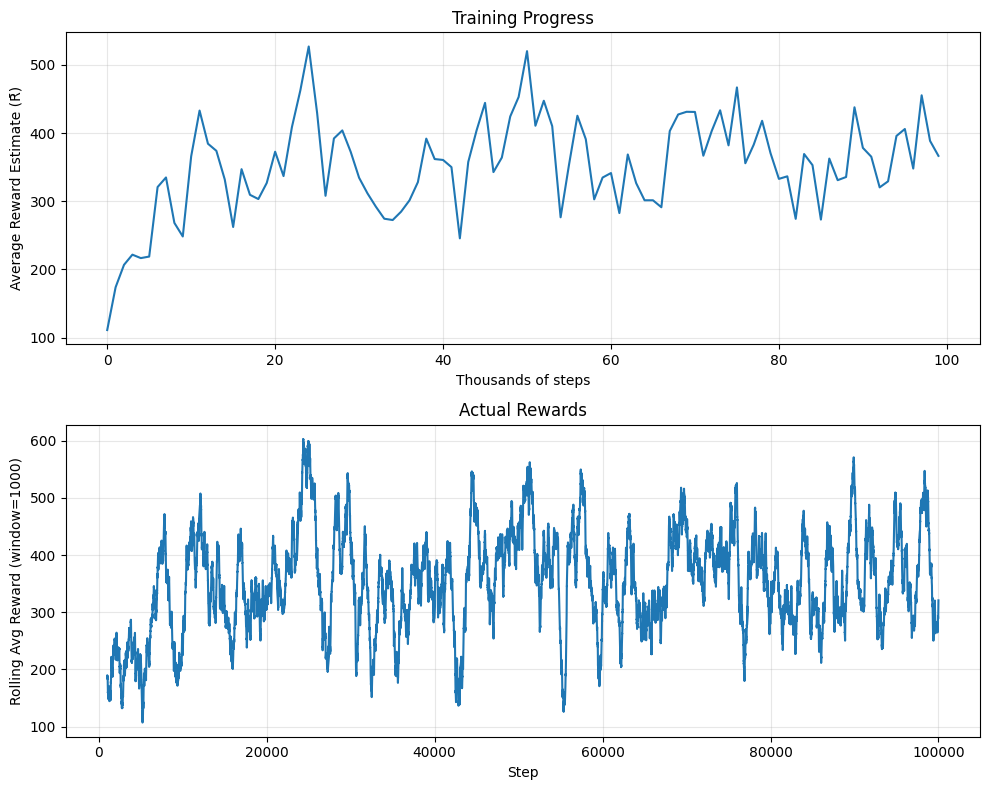

In [12]:
# ============================================================================
# Main Execution
# ============================================================================

if __name__ == "__main__":
    print("="*70)
    print("Actor-Critic Solution for Energy Trading")
    print("="*70)

    # Load your environment here
    # from your_module import EnvEnergyDiscrete, generate_discrete_set, settings
    env = EnvEnergyDiscrete(settings, a_w_tuple, a_c_tuple)

    # Create approximators
    print("\nCreating function approximators...")
    pi_hat = SoftmaxPolicyTabular(env, step_size=0.01)
    v_hat = ValueFunctionTileCoding(env, step_size=0.1, n_tilings=8, tiles_per_dim=8)

    # Train
    history = actor_critic_continuing(pi_hat, v_hat, env, steps=100000, alpha_r=0.001)

    # Evaluate
    avg_reward, std_reward = evaluate_policy(pi_hat, env, n_steps=10000)
    print(f"\nEvaluation: {avg_reward:.2f} ± {std_reward:.2f} EUR/hour")

    # Plot
    fig = plot_results(history)

2nd Try

In [11]:
"""
Actor-Critic Solution for Energy Trading (Q3)
Differential (average reward) formulation for continuing task
"""

import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

# Tile Coder
import hashlib

class TileCoder:
    def __init__(self, n_tilings, tiles_per_dim, ranges, seed=None):
        self.n_tilings = n_tilings
        self.tiles_per_dim = np.array(tiles_per_dim)
        self.ranges = np.array(ranges)
        self.d = len(ranges)

        # Deterministic offsets
        widths = 1.0 / self.tiles_per_dim
        t = np.arange(n_tilings).reshape(-1, 1)
        self.offsets = (t / n_tilings) * widths

        self.hash_size = 4096

    def _normalize(self, x):
        x = np.array(x)
        lo, hi = self.ranges[:, 0], self.ranges[:, 1]
        return np.clip((x - lo) / (hi - lo), 0, 1)

    def _hash(self, t, idxs):
        payload = np.array([t, *idxs], dtype=np.int64).tobytes()
        h = hashlib.sha256(payload).digest()
        return int.from_bytes(h[:8], 'little') % self.hash_size

    def active_indices(self, x):
        u = self._normalize(x)
        indices = []
        for t in range(self.n_tilings):
            v = u + self.offsets[t]
            idxs = tuple(min(int(np.floor(vi * tpd)), tpd-1)
                        for vi, tpd in zip(v, self.tiles_per_dim))
            indices.append(self._hash(t, idxs))
        return np.array(indices, dtype=int)

# Value Function
class ValueFunctionTileCoding:
    def __init__(self, env, step_size, n_tilings=8, tiles_per_dim=8):
        self.env = env
        self.alpha = step_size / n_tilings

        # State ranges
        ranges = [
            (0, env.settings['b_max']),           # s_l
            (-env.settings['b_max'], env.settings['c_max']),  # s_c
            (0, 30),                               # s_w
            (-50, 150)                             # s_p
        ]

        self.tc = TileCoder(n_tilings, [tiles_per_dim]*4, ranges)
        self.w = np.zeros(self.tc.hash_size)

    def eval(self, s):
        idxs = self.tc.active_indices(s)
        return float(np.sum(self.w[idxs]))

    def train(self, s, target):
        idxs = self.tc.active_indices(s)
        v_s = np.sum(self.w[idxs])
        delta = target - v_s
        self.w[idxs] += self.alpha * delta

# Policy (Softmax Tabular)
class SoftmaxPolicyTabular:
    def __init__(self, env, step_size, rng_seed=42):
        self.env = env
        self.alpha = step_size
        self.rng = np.random.default_rng(rng_seed)

        # All commitment actions
        self.actions = list(env.a_c_tuple)
        self.num_actions = len(self.actions)
        self.action_to_idx = {a: i for i, a in enumerate(self.actions)}

        # Discretize state space for tabular policy
        b_max = env.settings['b_max']
        c_max = env.settings['c_max']

        # State discretization: (s_l, s_c, s_w_bin, s_p_bin)
        self.s_l_bins = np.linspace(0, b_max, 6)  # 5 bins
        self.s_c_bins = np.linspace(-b_max, c_max, 8)  # 7 bins
        self.s_w_bins = np.array([0, 5, 10, 15, 30])  # 4 bins
        self.s_p_bins = np.array([-50, 0, 30, 60, 150])  # 4 bins

        self.n_states = 5 * 7 * 4 * 4  # Total discrete states

        # Preferences: θ[state_idx, action_idx]
        self.theta = np.zeros((self.n_states, self.num_actions))

    def _discretize_state(self, s):
        s_l, s_c, s_w, s_p = s
        i_l = np.digitize(s_l, self.s_l_bins) - 1
        i_c = np.digitize(s_c, self.s_c_bins) - 1
        i_w = np.digitize(s_w, self.s_w_bins) - 1
        i_p = np.digitize(s_p, self.s_p_bins) - 1

        # Flatten to single index
        idx = (i_l * 7 * 4 * 4 + i_c * 4 * 4 + i_w * 4 + i_p)
        return min(max(idx, 0), self.n_states - 1)

    def _softmax(self, prefs):
        c = np.max(prefs)
        exp_p = np.exp(prefs - c)
        return exp_p / np.sum(exp_p)

    def get_action(self, s):
        state_idx = self._discretize_state(s)

        # Get feasible actions
        env_actions = self.env.get_actions(s)
        feasible_a_c = [a[2] for a in env_actions]
        idxs = [self.action_to_idx[a] for a in feasible_a_c]

        # Softmax over feasible actions
        prefs = self.theta[state_idx, idxs]
        probs = self._softmax(prefs)

        chosen_idx = self.rng.choice(len(feasible_a_c), p=probs)
        return feasible_a_c[chosen_idx]

    def train(self, s, a_c, mult):
        state_idx = self._discretize_state(s)

        env_actions = self.env.get_actions(s)
        feasible_a_c = [a[2] for a in env_actions]
        idxs = np.array([self.action_to_idx[a] for a in feasible_a_c])

        prefs = self.theta[state_idx, idxs]
        probs = self._softmax(prefs)

        # Gradient
        j_taken = feasible_a_c.index(a_c)
        grad = -probs.copy()
        grad[j_taken] += 1.0

        # Update
        self.theta[state_idx, idxs] += self.alpha * mult * grad

# Actor-Critic Algorithm
def actor_critic_continuing(
    pi_hat,
    v_hat,
    steps: int,
    alpha_r: float,
    r_bar_ini: float = 0.0,
    callback = None,
    callback_every: int = 0,
    trace = None,
) -> None:
    """
    Differential (average-reward) one-step actor–critic for continuing tasks.

    Based on notebook Section 51 algorithm.

    Args:
        pi_hat: Policy (actor) with get_action(s) and train(s, a, mult).
        v_hat: Value function (critic) with eval(s) and train(s, target).
        steps: Total number of time steps to run.
        alpha_r: Step size for updating the average reward r̄.
        r_bar_ini: Initial average reward estimate.
        callback: Optional logging callback.
        callback_every: Call callback every this many steps (if > 0).
        trace: Passed through to callback (dict to store results).
    """

    # Initialize
    s = pi_hat.env.reset() if hasattr(pi_hat.env, 'reset') else [5.0, 5.0, 10.0, 40.0]
    r_bar = r_bar_ini

    total_reward = 0.0
    total_reward_every = 0.0

    for t in tqdm(range(1, steps + 1)):
        # Sample action from current policy
        a_c = pi_hat.get_action(s)

        # Get full action tuple (a_b, a_w, a_c)
        env_actions = pi_hat.env.get_actions(s)
        a = next((a for a in env_actions if a[2] == a_c), env_actions[0])

        # Environment step (continuing task: no 'done' flag)
        s_next, r = pi_hat.env.get_step(s, a)

        # Critic: TD error for differential value
        v_s = v_hat.eval(s)
        v_s_next = v_hat.eval(s_next)
        delta_t = r - r_bar + v_s_next - v_s

        # Actor: update with δ_t
        mult = delta_t
        pi_hat.train(s, a_c, mult)

        # Critic: semi-gradient TD(0) toward v_s + δ_t
        td_target = v_s + delta_t
        v_hat.train(s, td_target)

        # Average reward update
        r_bar += alpha_r * delta_t

        # Bookkeeping
        total_reward += r
        total_reward_every += r

        # Optional logging callback (in terms of steps, not episodes)
        if (
            callback is not None
            and callback_every > 0
            and t % callback_every == 0
        ):
            info = {
                "step": t,
                "avg_reward_estimate": r_bar,
                "avg_reward_overall": total_reward / t,
                "avg_reward_every": total_reward_every / callback_every,
            }
            total_reward_every = 0.0
            callback(pi_hat, info, trace)

        # Move to next state
        s = s_next

    print(f"Final average reward estimate: {r_bar:.2f}")

# Evaluation
def evaluate_policy(pi_hat, n_steps=10000):
    """Evaluate learned policy over n_steps"""
    env = pi_hat.env
    s = [5.0, 5.0, 10.0, 40.0]  # Initial state
    rewards = []

    for _ in range(n_steps):
        a_c = pi_hat.get_action(s)
        env_actions = env.get_actions(s)
        a = next((a for a in env_actions if a[2] == a_c), env_actions[0])
        s, r = env.get_step(s, a)
        rewards.append(r)

    return np.mean(rewards), np.std(rewards)

# Visualization
def plot_results(trace):
    """Plot training results from trace dict"""
    import pandas as pd

    fig, ax1 = plt.subplots(1, 1, figsize=(10, 6))

    # Average reward estimate
    ax1.plot(trace['r_bar_history'], linewidth=2)
    ax1.set_xlabel('Callback Interval (x1000 steps)')
    ax1.set_ylabel('Average Reward Estimate (R̄)')
    ax1.set_title('Actor-Critic Training Progress')
    ax1.grid(True, alpha=0.3)

    plt.tight_layout()
    return fig

In [12]:
# Main Execution (following notebook pattern)

# Setup environment
env = EnvEnergyDiscrete(settings, a_w_tuple, a_c_tuple)

# Create approximators
pi_hat = SoftmaxPolicyTabular(env, step_size=0.01)
v_hat = ValueFunctionTileCoding(env, step_size=0.1, n_tilings=8, tiles_per_dim=8)

# Create trace dict to store results
trace = {'r_bar_history': [], 'rewards': []}

# Define callback function (following notebook pattern)
def callback(pi_hat, info, trace):
    step = info['step']
    r_bar = info['avg_reward_estimate']
    avg_every = info['avg_reward_every']

    # Store history
    trace['r_bar_history'].append(r_bar)

    # Print progress
    print(f"\nStep {step:6d} | R̄={r_bar:7.2f} | Avg(window)={avg_every:7.2f}")

# Train using actor-critic
actor_critic_continuing(
    pi_hat=pi_hat,
    v_hat=v_hat,
    steps=100000,
    alpha_r=0.001,
    r_bar_ini=0.0,
    callback=callback,
    callback_every=1000,
    trace=trace
)

# Evaluate learned policy
avg_reward, std_reward = evaluate_policy(pi_hat, env, n_steps=10000)
print(f"Evaluation: {avg_reward:.2f} ± {std_reward:.2f} EUR/hour")

# Plot results
if trace['r_bar_history']:
    fig = plot_results(trace)
    plt.savefig('actor_critic_results.png', dpi=150)

Price model loaded successfully from prices_ar1.pkl.gz
Wind model loaded successfully from wind_log_ar1.pkl.gz


  1%|          | 1111/100000 [00:01<02:51, 577.48it/s]


Step   1000 | R̄= 111.04 | Avg(window)= 188.82


  2%|▏         | 2115/100000 [00:03<02:53, 563.47it/s]


Step   2000 | R̄= 173.83 | Avg(window)= 219.96


  3%|▎         | 3104/100000 [00:05<02:50, 569.15it/s]


Step   3000 | R̄= 206.68 | Avg(window)= 211.73


  4%|▍         | 4101/100000 [00:07<02:45, 580.77it/s]


Step   4000 | R̄= 221.60 | Avg(window)= 230.83


  5%|▌         | 5047/100000 [00:09<04:16, 369.55it/s]


Step   5000 | R̄= 216.56 | Avg(window)= 210.42


  6%|▌         | 6070/100000 [00:11<02:42, 577.21it/s]


Step   6000 | R̄= 218.80 | Avg(window)= 209.09


  7%|▋         | 7115/100000 [00:13<02:44, 564.68it/s]


Step   7000 | R̄= 320.73 | Avg(window)= 370.69


  8%|▊         | 8102/100000 [00:15<02:43, 561.48it/s]


Step   8000 | R̄= 334.81 | Avg(window)= 376.85


  9%|▉         | 9092/100000 [00:17<02:38, 572.93it/s]


Step   9000 | R̄= 268.18 | Avg(window)= 246.41


 10%|█         | 10085/100000 [00:18<02:37, 571.11it/s]


Step  10000 | R̄= 248.27 | Avg(window)= 227.91


 11%|█         | 11046/100000 [00:20<03:23, 437.18it/s]


Step  11000 | R̄= 365.80 | Avg(window)= 449.37


 12%|█▏        | 12092/100000 [00:23<03:02, 482.37it/s]


Step  12000 | R̄= 432.91 | Avg(window)= 454.91


 13%|█▎        | 13102/100000 [00:25<02:40, 539.97it/s]


Step  13000 | R̄= 384.27 | Avg(window)= 353.98


 14%|█▍        | 14058/100000 [00:26<02:36, 549.74it/s]


Step  14000 | R̄= 373.88 | Avg(window)= 342.71


 15%|█▌        | 15078/100000 [00:28<02:39, 530.85it/s]


Step  15000 | R̄= 331.85 | Avg(window)= 302.80


 16%|█▌        | 16106/100000 [00:30<02:33, 545.28it/s]


Step  16000 | R̄= 262.18 | Avg(window)= 215.15


 17%|█▋        | 17095/100000 [00:32<02:23, 577.32it/s]


Step  17000 | R̄= 346.97 | Avg(window)= 422.34


 18%|█▊        | 18041/100000 [00:34<03:24, 400.87it/s]


Step  18000 | R̄= 309.38 | Avg(window)= 278.49


 19%|█▉        | 19107/100000 [00:36<02:23, 564.03it/s]


Step  19000 | R̄= 303.16 | Avg(window)= 313.18


 20%|██        | 20105/100000 [00:38<02:18, 576.58it/s]


Step  20000 | R̄= 326.74 | Avg(window)= 330.68


 21%|██        | 21101/100000 [00:40<02:22, 554.52it/s]


Step  21000 | R̄= 372.55 | Avg(window)= 397.76


 22%|██▏       | 22074/100000 [00:42<02:17, 568.31it/s]


Step  22000 | R̄= 336.84 | Avg(window)= 305.67


 23%|██▎       | 23067/100000 [00:44<02:20, 548.19it/s]


Step  23000 | R̄= 408.73 | Avg(window)= 428.08


 24%|██▍       | 24070/100000 [00:46<03:04, 411.73it/s]


Step  24000 | R̄= 462.38 | Avg(window)= 464.70


 25%|██▌       | 25111/100000 [00:48<02:21, 527.77it/s]


Step  25000 | R̄= 526.85 | Avg(window)= 566.38


 26%|██▌       | 26100/100000 [00:50<02:06, 583.08it/s]


Step  26000 | R̄= 429.37 | Avg(window)= 396.90


 27%|██▋       | 27093/100000 [00:52<02:07, 573.05it/s]


Step  27000 | R̄= 307.93 | Avg(window)= 252.47


 28%|██▊       | 28079/100000 [00:54<02:11, 545.00it/s]


Step  28000 | R̄= 392.01 | Avg(window)= 412.79


 29%|██▉       | 29067/100000 [00:55<02:11, 540.14it/s]


Step  29000 | R̄= 403.80 | Avg(window)= 400.00


 30%|███       | 30062/100000 [00:57<01:59, 585.64it/s]


Step  30000 | R̄= 372.34 | Avg(window)= 410.49


 31%|███       | 31050/100000 [00:59<02:56, 389.78it/s]


Step  31000 | R̄= 334.37 | Avg(window)= 313.81


 32%|███▏      | 32110/100000 [01:02<01:58, 573.89it/s]


Step  32000 | R̄= 311.44 | Avg(window)= 338.22


 33%|███▎      | 33113/100000 [01:03<01:55, 579.59it/s]


Step  33000 | R̄= 291.90 | Avg(window)= 259.68


 34%|███▍      | 34107/100000 [01:05<01:55, 572.74it/s]


Step  34000 | R̄= 274.31 | Avg(window)= 299.60


 35%|███▌      | 35102/100000 [01:08<02:13, 486.92it/s]


Step  35000 | R̄= 272.38 | Avg(window)= 332.79


 36%|███▌      | 36087/100000 [01:10<01:53, 563.81it/s]


Step  36000 | R̄= 284.64 | Avg(window)= 290.76


 37%|███▋      | 37067/100000 [01:12<02:39, 395.33it/s]


Step  37000 | R̄= 301.21 | Avg(window)= 304.83


 38%|███▊      | 38103/100000 [01:14<01:48, 571.25it/s]


Step  38000 | R̄= 327.90 | Avg(window)= 368.79


 39%|███▉      | 39089/100000 [01:16<01:47, 567.67it/s]


Step  39000 | R̄= 391.77 | Avg(window)= 432.65


 40%|████      | 40088/100000 [01:18<01:45, 565.39it/s]


Step  40000 | R̄= 361.81 | Avg(window)= 315.99


 41%|████      | 41092/100000 [01:19<01:43, 566.69it/s]


Step  41000 | R̄= 360.49 | Avg(window)= 348.88


 42%|████▏     | 42094/100000 [01:21<01:38, 586.93it/s]


Step  42000 | R̄= 349.96 | Avg(window)= 350.96


 43%|████▎     | 43104/100000 [01:23<01:38, 575.26it/s]


Step  43000 | R̄= 245.54 | Avg(window)= 154.58


 44%|████▍     | 44043/100000 [01:25<02:24, 386.59it/s]


Step  44000 | R̄= 357.52 | Avg(window)= 395.79


 45%|████▌     | 45093/100000 [01:27<01:36, 569.31it/s]


Step  45000 | R̄= 404.13 | Avg(window)= 453.65


 46%|████▌     | 46091/100000 [01:29<01:36, 557.04it/s]


Step  46000 | R̄= 444.20 | Avg(window)= 438.59


 47%|████▋     | 47097/100000 [01:31<01:32, 572.12it/s]


Step  47000 | R̄= 342.69 | Avg(window)= 258.21


 48%|████▊     | 48095/100000 [01:33<01:30, 571.49it/s]


Step  48000 | R̄= 363.99 | Avg(window)= 405.49


 49%|████▉     | 49094/100000 [01:34<01:29, 569.14it/s]


Step  49000 | R̄= 424.25 | Avg(window)= 453.80


 50%|█████     | 50067/100000 [01:36<01:56, 427.43it/s]


Step  50000 | R̄= 452.80 | Avg(window)= 450.73


 51%|█████     | 51090/100000 [01:39<01:42, 478.36it/s]


Step  51000 | R̄= 520.03 | Avg(window)= 525.02


 52%|█████▏    | 52081/100000 [01:40<01:26, 551.16it/s]


Step  52000 | R̄= 410.66 | Avg(window)= 370.61


 53%|█████▎    | 53074/100000 [01:42<01:21, 577.91it/s]


Step  53000 | R̄= 447.30 | Avg(window)= 433.81


 54%|█████▍    | 54063/100000 [01:44<01:21, 563.44it/s]


Step  54000 | R̄= 410.05 | Avg(window)= 356.82


 55%|█████▌    | 55054/100000 [01:46<01:25, 523.96it/s]


Step  55000 | R̄= 276.41 | Avg(window)= 249.59


 56%|█████▌    | 56104/100000 [01:48<01:16, 572.25it/s]


Step  56000 | R̄= 353.45 | Avg(window)= 383.49


 57%|█████▋    | 57042/100000 [01:50<01:48, 397.34it/s]


Step  57000 | R̄= 425.33 | Avg(window)= 448.24


 58%|█████▊    | 58087/100000 [01:52<01:14, 561.58it/s]


Step  58000 | R̄= 390.93 | Avg(window)= 411.89


 59%|█████▉    | 59077/100000 [01:54<01:11, 570.06it/s]


Step  59000 | R̄= 302.67 | Avg(window)= 296.12


 60%|██████    | 60069/100000 [01:55<01:11, 562.14it/s]


Step  60000 | R̄= 334.67 | Avg(window)= 322.27


 61%|██████    | 61057/100000 [01:57<01:09, 558.50it/s]


Step  61000 | R̄= 341.32 | Avg(window)= 352.32


 62%|██████▏   | 62108/100000 [01:59<01:06, 571.66it/s]


Step  62000 | R̄= 282.55 | Avg(window)= 281.82


 63%|██████▎   | 63093/100000 [02:01<01:05, 567.78it/s]


Step  63000 | R̄= 368.54 | Avg(window)= 432.78


 64%|██████▍   | 64038/100000 [02:03<01:37, 367.19it/s]


Step  64000 | R̄= 326.47 | Avg(window)= 324.53


 65%|██████▌   | 65079/100000 [02:05<01:00, 575.81it/s]


Step  65000 | R̄= 301.32 | Avg(window)= 284.39


 66%|██████▌   | 66074/100000 [02:07<00:59, 569.35it/s]


Step  66000 | R̄= 301.35 | Avg(window)= 302.70


 67%|██████▋   | 67065/100000 [02:09<00:59, 554.63it/s]


Step  67000 | R̄= 291.12 | Avg(window)= 287.48


 68%|██████▊   | 68062/100000 [02:10<00:55, 579.26it/s]


Step  68000 | R̄= 402.87 | Avg(window)= 449.51


 69%|██████▉   | 69058/100000 [02:12<00:54, 568.29it/s]


Step  69000 | R̄= 427.17 | Avg(window)= 416.39


 70%|███████   | 70057/100000 [02:14<01:16, 391.33it/s]


Step  70000 | R̄= 431.11 | Avg(window)= 443.05


 71%|███████   | 71075/100000 [02:17<00:55, 525.30it/s]


Step  71000 | R̄= 430.89 | Avg(window)= 413.17


 72%|███████▏  | 72109/100000 [02:18<00:49, 562.42it/s]


Step  72000 | R̄= 366.71 | Avg(window)= 320.80


 73%|███████▎  | 73106/100000 [02:20<00:48, 557.80it/s]


Step  73000 | R̄= 403.09 | Avg(window)= 436.95


 74%|███████▍  | 74097/100000 [02:22<00:44, 575.95it/s]


Step  74000 | R̄= 433.32 | Avg(window)= 428.83


 75%|███████▌  | 75082/100000 [02:24<00:44, 554.63it/s]


Step  75000 | R̄= 381.88 | Avg(window)= 345.36


 76%|███████▌  | 76070/100000 [02:25<00:42, 563.02it/s]


Step  76000 | R̄= 466.84 | Avg(window)= 523.55


 77%|███████▋  | 77077/100000 [02:28<01:00, 380.00it/s]


Step  77000 | R̄= 355.65 | Avg(window)= 229.82


 78%|███████▊  | 78111/100000 [02:30<00:38, 568.58it/s]


Step  78000 | R̄= 382.87 | Avg(window)= 387.33


 79%|███████▉  | 79098/100000 [02:32<00:36, 574.24it/s]


Step  79000 | R̄= 417.90 | Avg(window)= 432.11


 80%|████████  | 80091/100000 [02:33<00:34, 576.39it/s]


Step  80000 | R̄= 370.49 | Avg(window)= 302.70


 81%|████████  | 81081/100000 [02:35<00:33, 572.16it/s]


Step  81000 | R̄= 332.73 | Avg(window)= 334.93


 82%|████████▏ | 82061/100000 [02:37<00:34, 516.01it/s]


Step  82000 | R̄= 336.48 | Avg(window)= 327.65


 83%|████████▎ | 83034/100000 [02:39<00:30, 563.11it/s]


Step  83000 | R̄= 274.14 | Avg(window)= 241.67


 84%|████████▍ | 84093/100000 [02:42<00:34, 454.82it/s]


Step  84000 | R̄= 369.19 | Avg(window)= 447.72


 85%|████████▌ | 85064/100000 [02:43<00:27, 540.67it/s]


Step  85000 | R̄= 352.91 | Avg(window)= 326.92


 86%|████████▌ | 86109/100000 [02:45<00:23, 580.90it/s]


Step  86000 | R̄= 273.06 | Avg(window)= 228.43


 87%|████████▋ | 87099/100000 [02:47<00:22, 570.10it/s]


Step  87000 | R̄= 362.51 | Avg(window)= 424.40


 88%|████████▊ | 88093/100000 [02:49<00:21, 548.76it/s]


Step  88000 | R̄= 330.83 | Avg(window)= 315.66


 89%|████████▉ | 89090/100000 [02:50<00:18, 581.46it/s]


Step  89000 | R̄= 335.47 | Avg(window)= 320.19


 90%|█████████ | 90068/100000 [02:53<00:25, 389.52it/s]


Step  90000 | R̄= 437.70 | Avg(window)= 528.20


 91%|█████████ | 91065/100000 [02:55<00:16, 551.40it/s]


Step  91000 | R̄= 378.23 | Avg(window)= 317.52


 92%|█████████▏| 92112/100000 [02:57<00:13, 569.35it/s]


Step  92000 | R̄= 365.26 | Avg(window)= 383.67


 93%|█████████▎| 93102/100000 [02:58<00:12, 571.98it/s]


Step  93000 | R̄= 320.27 | Avg(window)= 316.66


 94%|█████████▍| 94096/100000 [03:00<00:10, 560.77it/s]


Step  94000 | R̄= 329.14 | Avg(window)= 332.15


 95%|█████████▌| 95089/100000 [03:02<00:08, 575.19it/s]


Step  95000 | R̄= 395.69 | Avg(window)= 449.69


 96%|█████████▌| 96081/100000 [03:04<00:06, 562.19it/s]


Step  96000 | R̄= 405.87 | Avg(window)= 408.19


 97%|█████████▋| 97050/100000 [03:06<00:07, 389.78it/s]


Step  97000 | R̄= 347.89 | Avg(window)= 292.03


 98%|█████████▊| 98063/100000 [03:08<00:03, 569.85it/s]


Step  98000 | R̄= 455.29 | Avg(window)= 483.87


 99%|█████████▉| 99100/100000 [03:10<00:01, 571.35it/s]


Step  99000 | R̄= 388.51 | Avg(window)= 369.17


100%|██████████| 100000/100000 [03:12<00:00, 520.73it/s]


Step 100000 | R̄= 366.48 | Avg(window)= 320.86
Final average reward estimate: 366.48


TypeError: evaluate_policy() got multiple values for argument 'n_steps'

3rd attempt

In [13]:
"""
Actor-Critic Solution for Energy Trading with CONTINUOUS Actions
"""

import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

# Tile Coder (same as before)
import hashlib

class TileCoder:
    def __init__(self, n_tilings, tiles_per_dim, ranges, seed=None):
        self.n_tilings = n_tilings
        self.tiles_per_dim = np.array(tiles_per_dim)
        self.ranges = np.array(ranges)
        self.d = len(ranges)

        widths = 1.0 / self.tiles_per_dim
        t = np.arange(n_tilings).reshape(-1, 1)
        self.offsets = (t / n_tilings) * widths

        self.hash_size = 4096

    def _normalize(self, x):
        x = np.array(x)
        lo, hi = self.ranges[:, 0], self.ranges[:, 1]
        return np.clip((x - lo) / (hi - lo), 0, 1)

    def _hash(self, t, idxs):
        payload = np.array([t, *idxs], dtype=np.int64).tobytes()
        h = hashlib.sha256(payload).digest()
        return int.from_bytes(h[:8], 'little') % self.hash_size

    def active_indices(self, x):
        u = self._normalize(x)
        indices = []
        for t in range(self.n_tilings):
            v = u + self.offsets[t]
            idxs = tuple(min(int(np.floor(vi * tpd)), tpd-1)
                        for vi, tpd in zip(v, self.tiles_per_dim))
            indices.append(self._hash(t, idxs))
        return np.array(indices, dtype=int)

# Value Function (same as before)
class ValueFunctionTileCoding:
    def __init__(self, env, step_size, n_tilings=8, tiles_per_dim=8):
        self.env = env
        self.alpha = step_size / n_tilings

        ranges = [
            (0, env.settings['b_max']),
            (-env.settings['b_max'], env.settings['c_max']),
            (0, 30),
            (-50, 150)
        ]

        self.tc = TileCoder(n_tilings, [tiles_per_dim]*4, ranges)
        self.w = np.zeros(self.tc.hash_size)

    def eval(self, s):
        idxs = self.tc.active_indices(s)
        return float(np.sum(self.w[idxs]))

    def train(self, s, target):
        idxs = self.tc.active_indices(s)
        v_s = np.sum(self.w[idxs])
        delta = target - v_s
        self.w[idxs] += self.alpha * delta

# MODIFIED: Gaussian Policy for Continuous Actions
class GaussianPolicyTileCoding:
    """
    Gaussian policy using tile coding for the mean.
    Only learns a_c (commitment), as a_b and a_w are determined by state.
    """
    def __init__(self, env, step_size, sigma=10.0, n_tilings=8, tiles_per_dim=8, rng_seed=42):
        self.env = env
        self.alpha = step_size / n_tilings
        self.sigma = sigma  # Fixed standard deviation
        self.rng = np.random.default_rng(rng_seed)

        # State ranges (same as value function)
        ranges = [
            (0, env.settings['b_max']),
            (-env.settings['b_max'], env.settings['c_max']),
            (0, 30),
            (-50, 150)
        ]

        self.tc = TileCoder(n_tilings, [tiles_per_dim]*4, ranges)
        self.w = np.zeros(self.tc.hash_size)

    def _mean(self, s):
        """Get mean of Gaussian policy for state s"""
        idxs = self.tc.active_indices(s)
        return float(np.sum(self.w[idxs]))

    def get_action(self, s):
        """Sample a_c from Gaussian policy, return full action tuple"""
        a_b, a_w, a_c_min = self.env.get_action_info(s)

        # Sample a_c from Gaussian
        mu = self._mean(s)
        a_c = self.rng.normal(mu, self.sigma)

        # Clip to valid range [a_c_min, c_max]
        a_c_max = self.env.settings['c_max']
        a_c = np.clip(a_c, a_c_min, a_c_max)

        return (float(a_b), float(a_w), float(a_c))

    def train(self, s, a_c, mult):
        """Update policy using policy gradient for Gaussian"""
        idxs = self.tc.active_indices(s)
        mu = np.sum(self.w[idxs])

        # Gaussian policy gradient: ∇log π(a|s) = (a - μ) / σ²
        grad_log_pi = (a_c - mu) / (self.sigma ** 2)

        self.w[idxs] += self.alpha * mult * grad_log_pi

# MODIFIED: Actor-Critic Algorithm
def actor_critic_continuing(
    pi_hat,
    v_hat,
    steps: int,
    alpha_r: float,
    r_bar_ini: float = 0.0,
    callback = None,
    callback_every: int = 0,
    trace = None,
) -> None:
    """
    Differential (average-reward) one-step actor–critic for continuing tasks
    with continuous actions.
    """

    # Initialize
    s = [5.0, 5.0, 10.0, 40.0]
    r_bar = r_bar_ini

    total_reward = 0.0
    total_reward_every = 0.0

    for t in tqdm(range(1, steps + 1)):
        # Sample action from policy (returns full tuple)
        a = pi_hat.get_action(s)
        a_b, a_w, a_c = a

        # Environment step
        s_next, r = pi_hat.env.get_step(s, a)

        # Critic: TD error
        v_s = v_hat.eval(s)
        v_s_next = v_hat.eval(s_next)
        delta_t = r - r_bar + v_s_next - v_s

        # Actor: update with δ_t
        pi_hat.train(s, a_c, delta_t)

        # Critic: semi-gradient TD(0)
        td_target = v_s + delta_t
        v_hat.train(s, td_target)

        # Average reward update
        r_bar += alpha_r * delta_t

        # Bookkeeping
        total_reward += r
        total_reward_every += r

        # Callback
        if callback is not None and callback_every > 0 and t % callback_every == 0:
            info = {
                "step": t,
                "avg_reward_estimate": r_bar,
                "avg_reward_overall": total_reward / t,
                "avg_reward_every": total_reward_every / callback_every,
            }
            total_reward_every = 0.0
            callback(pi_hat, info, trace)

        s = s_next

    print(f"\nFinal average reward estimate: {r_bar:.2f}")

# MODIFIED: Evaluation
def evaluate_policy(pi_hat, n_steps=10000):
    """Evaluate learned policy"""
    env = pi_hat.env
    s = [5.0, 5.0, 10.0, 40.0]
    rewards = []

    for _ in range(n_steps):
        a = pi_hat.get_action(s)
        s, r = env.get_step(s, a)
        rewards.append(r)

    return np.mean(rewards), np.std(rewards)

# Visualization (same)
def plot_results(trace):
    """Plot training results"""
    fig, ax1 = plt.subplots(1, 1, figsize=(10, 6))

    ax1.plot(trace['r_bar_history'], linewidth=2)
    ax1.set_xlabel('Callback Interval (x1000 steps)')
    ax1.set_ylabel('Average Reward Estimate (R̄)')
    ax1.set_title('Actor-Critic Training Progress (Continuous Actions)')
    ax1.grid(True, alpha=0.3)

    plt.tight_layout()
    return fig

Price model loaded successfully from prices_ar1.pkl.gz
Wind model loaded successfully from wind_log_ar1.pkl.gz
Training with Continuous Environment (EnvEnergyCont)


  1%|          | 1111/100000 [00:01<02:54, 565.68it/s]


Step   1000 | R̄=  87.18 | Avg(window)= 138.64


  2%|▏         | 2098/100000 [00:03<02:55, 557.82it/s]


Step   2000 | R̄= 118.51 | Avg(window)= 148.09


  3%|▎         | 3067/100000 [00:06<04:33, 354.77it/s]


Step   3000 | R̄= 141.61 | Avg(window)= 146.74


  4%|▍         | 4113/100000 [00:08<02:49, 567.04it/s]


Step   4000 | R̄= 152.83 | Avg(window)= 159.51


  5%|▌         | 5103/100000 [00:09<02:51, 554.28it/s]


Step   5000 | R̄= 157.01 | Avg(window)= 159.88


  6%|▌         | 6097/100000 [00:11<02:43, 573.32it/s]


Step   6000 | R̄= 169.26 | Avg(window)= 162.46


  7%|▋         | 7074/100000 [00:13<02:42, 572.98it/s]


Step   7000 | R̄= 258.24 | Avg(window)= 303.13


  8%|▊         | 8064/100000 [00:15<02:42, 564.41it/s]


Step   8000 | R̄= 261.32 | Avg(window)= 280.85


  9%|▉         | 9056/100000 [00:17<03:50, 394.69it/s]


Step   9000 | R̄= 280.67 | Avg(window)= 300.37


 10%|█         | 10092/100000 [00:19<02:45, 542.16it/s]


Step  10000 | R̄= 304.25 | Avg(window)= 305.21


 11%|█         | 11111/100000 [00:21<02:39, 558.11it/s]


Step  11000 | R̄= 531.37 | Avg(window)= 662.41


 12%|█▏        | 12093/100000 [00:23<02:38, 555.17it/s]


Step  12000 | R̄= 800.34 | Avg(window)= 916.07


 13%|█▎        | 13088/100000 [00:25<02:30, 577.17it/s]


Step  13000 | R̄= 843.32 | Avg(window)= 847.43


 14%|█▍        | 14103/100000 [00:26<02:34, 557.04it/s]


Step  14000 | R̄= 941.01 | Avg(window)= 940.55


 15%|█▌        | 15088/100000 [00:28<02:33, 553.80it/s]


Step  15000 | R̄= 942.22 | Avg(window)= 941.21


 16%|█▌        | 16041/100000 [00:31<03:42, 376.53it/s]


Step  16000 | R̄= 815.80 | Avg(window)= 758.47


 17%|█▋        | 17060/100000 [00:33<02:25, 568.12it/s]


Step  17000 | R̄=1055.29 | Avg(window)=1241.50


 18%|█▊        | 18102/100000 [00:34<02:29, 549.23it/s]


Step  18000 | R̄=1017.64 | Avg(window)= 988.19


 19%|█▉        | 19100/100000 [00:36<02:19, 578.39it/s]


Step  19000 | R̄=1051.94 | Avg(window)=1106.21


 20%|██        | 20082/100000 [00:38<02:25, 547.83it/s]


Step  20000 | R̄=1163.76 | Avg(window)=1190.95


 21%|██        | 21077/100000 [00:40<02:20, 560.22it/s]


Step  21000 | R̄=1226.40 | Avg(window)=1253.93


 22%|██▏       | 22054/100000 [00:42<02:54, 446.10it/s]


Step  22000 | R̄=1158.85 | Avg(window)=1092.26


 23%|██▎       | 23077/100000 [00:44<02:48, 455.94it/s]


Step  23000 | R̄=1307.54 | Avg(window)=1344.87


 24%|██▍       | 24065/100000 [00:46<02:16, 556.42it/s]


Step  24000 | R̄=1417.19 | Avg(window)=1442.64


 25%|██▌       | 25060/100000 [00:48<02:15, 552.30it/s]


Step  25000 | R̄=1578.05 | Avg(window)=1680.39


 26%|██▌       | 26104/100000 [00:50<02:09, 571.55it/s]


Step  26000 | R̄=1349.37 | Avg(window)=1271.66


 27%|██▋       | 27098/100000 [00:51<02:09, 562.85it/s]


Step  27000 | R̄=1163.06 | Avg(window)=1097.35


 28%|██▊       | 28087/100000 [00:53<02:04, 575.67it/s]


Step  28000 | R̄=1288.51 | Avg(window)=1306.36


 29%|██▉       | 29075/100000 [00:55<02:58, 397.74it/s]


Step  29000 | R̄=1295.98 | Avg(window)=1270.10


 30%|███       | 30054/100000 [00:58<02:04, 561.37it/s]


Step  30000 | R̄=1209.14 | Avg(window)=1282.66


 31%|███       | 31080/100000 [00:59<01:59, 578.59it/s]


Step  31000 | R̄=1166.39 | Avg(window)=1157.71


 32%|███▏      | 32071/100000 [01:01<01:58, 574.27it/s]


Step  32000 | R̄=1107.22 | Avg(window)=1171.83


 33%|███▎      | 33118/100000 [01:03<01:59, 560.18it/s]


Step  33000 | R̄=1022.25 | Avg(window)= 950.09


 34%|███▍      | 34081/100000 [01:05<02:05, 525.41it/s]


Step  34000 | R̄=1027.16 | Avg(window)=1097.21


 35%|███▌      | 35046/100000 [01:07<02:00, 537.95it/s]


Step  35000 | R̄=1028.40 | Avg(window)=1157.23


 36%|███▌      | 36076/100000 [01:09<02:24, 443.50it/s]


Step  36000 | R̄=1086.02 | Avg(window)=1129.52


 37%|███▋      | 37089/100000 [01:11<01:54, 547.11it/s]


Step  37000 | R̄=1112.98 | Avg(window)=1121.80


 38%|███▊      | 38065/100000 [01:13<01:58, 523.47it/s]


Step  38000 | R̄=1163.68 | Avg(window)=1250.75


 39%|███▉      | 39098/100000 [01:15<01:47, 566.37it/s]


Step  39000 | R̄=1256.21 | Avg(window)=1344.63


 40%|████      | 40080/100000 [01:17<01:48, 553.09it/s]


Step  40000 | R̄=1208.34 | Avg(window)=1151.80


 41%|████      | 41056/100000 [01:18<01:47, 548.09it/s]


Step  41000 | R̄=1202.55 | Avg(window)=1155.99


 42%|████▏     | 42070/100000 [01:21<02:36, 371.13it/s]


Step  42000 | R̄=1173.70 | Avg(window)=1171.21


 43%|████▎     | 43065/100000 [01:23<01:43, 552.25it/s]


Step  43000 | R̄=1027.59 | Avg(window)= 894.14


 44%|████▍     | 44053/100000 [01:25<01:40, 555.11it/s]


Step  44000 | R̄=1191.66 | Avg(window)=1249.14


 45%|████▌     | 45095/100000 [01:27<01:37, 563.78it/s]


Step  45000 | R̄=1274.06 | Avg(window)=1357.83


 46%|████▌     | 46077/100000 [01:28<01:35, 563.10it/s]


Step  46000 | R̄=1379.16 | Avg(window)=1399.51


 47%|████▋     | 47062/100000 [01:30<01:35, 557.21it/s]


Step  47000 | R̄=1198.97 | Avg(window)=1066.92


 48%|████▊     | 48093/100000 [01:32<01:41, 509.79it/s]


Step  48000 | R̄=1218.18 | Avg(window)=1283.49


 49%|████▉     | 49037/100000 [01:35<02:24, 352.89it/s]


Step  49000 | R̄=1171.93 | Avg(window)=1153.88


 50%|█████     | 50105/100000 [01:36<01:31, 547.89it/s]


Step  50000 | R̄= 845.10 | Avg(window)= 681.27


 51%|█████     | 51098/100000 [01:38<01:34, 519.63it/s]


Step  51000 | R̄= 480.78 | Avg(window)= 276.42


 52%|█████▏    | 52068/100000 [01:40<01:23, 571.04it/s]


Step  52000 | R̄= 230.81 | Avg(window)=  96.10


 53%|█████▎    | 53097/100000 [01:42<01:25, 545.83it/s]


Step  53000 | R̄= 137.74 | Avg(window)=  76.82


 54%|█████▍    | 54067/100000 [01:44<01:23, 549.29it/s]


Step  54000 | R̄=  89.13 | Avg(window)=  62.83


 55%|█████▌    | 55041/100000 [01:47<02:40, 280.85it/s]


Step  55000 | R̄=  81.44 | Avg(window)=  77.65


 56%|█████▌    | 56057/100000 [01:49<01:21, 535.91it/s]


Step  56000 | R̄=  91.90 | Avg(window)=  97.74


 57%|█████▋    | 57094/100000 [01:51<01:20, 532.13it/s]


Step  57000 | R̄= 100.97 | Avg(window)= 108.40


 58%|█████▊    | 58067/100000 [01:53<01:14, 561.20it/s]


Step  58000 | R̄= 112.03 | Avg(window)= 130.43


 59%|█████▉    | 59107/100000 [01:54<01:12, 565.40it/s]


Step  59000 | R̄=  75.69 | Avg(window)=  62.00


 60%|██████    | 60083/100000 [01:56<01:13, 546.44it/s]


Step  60000 | R̄=  47.10 | Avg(window)=  27.89


 61%|██████    | 61041/100000 [01:58<01:48, 358.10it/s]


Step  61000 | R̄=  37.38 | Avg(window)=  31.28


 62%|██████▏   | 62099/100000 [02:01<01:11, 528.00it/s]


Step  62000 | R̄=  17.53 | Avg(window)=   7.15


 63%|██████▎   | 63071/100000 [02:03<01:08, 537.72it/s]


Step  63000 | R̄=  22.69 | Avg(window)=  27.03


 64%|██████▍   | 64077/100000 [02:04<01:03, 564.82it/s]


Step  64000 | R̄=  36.66 | Avg(window)=  45.60


 65%|██████▌   | 65108/100000 [02:06<01:02, 553.93it/s]


Step  65000 | R̄=  19.73 | Avg(window)=   7.95


 66%|██████▌   | 66065/100000 [02:08<01:05, 521.00it/s]


Step  66000 | R̄=  22.25 | Avg(window)=  25.92


 67%|██████▋   | 67099/100000 [02:10<01:00, 545.43it/s]


Step  67000 | R̄=  28.57 | Avg(window)=  28.79


 68%|██████▊   | 68056/100000 [02:12<01:28, 362.11it/s]


Step  68000 | R̄=  31.19 | Avg(window)=  31.65


 69%|██████▉   | 69081/100000 [02:14<00:54, 564.49it/s]


Step  69000 | R̄=  33.65 | Avg(window)=  32.32


 70%|███████   | 70060/100000 [02:16<00:54, 545.34it/s]


Step  70000 | R̄=  45.08 | Avg(window)=  52.79


 71%|███████   | 71094/100000 [02:18<00:51, 557.14it/s]


Step  71000 | R̄=  24.95 | Avg(window)=  14.12


 72%|███████▏  | 72072/100000 [02:20<00:49, 563.23it/s]


Step  72000 | R̄=  11.98 | Avg(window)=   5.20


 73%|███████▎  | 73107/100000 [02:22<00:48, 556.80it/s]


Step  73000 | R̄=  10.55 | Avg(window)=   9.06


 74%|███████▍  | 74054/100000 [02:24<01:10, 368.41it/s]


Step  74000 | R̄=   6.46 | Avg(window)=   2.27


 75%|███████▌  | 75087/100000 [02:26<00:44, 555.75it/s]


Step  75000 | R̄=   9.27 | Avg(window)=  10.69


 76%|███████▌  | 76094/100000 [02:29<00:52, 457.22it/s]


Step  76000 | R̄=   6.63 | Avg(window)=   4.89


 77%|███████▋  | 77092/100000 [02:30<00:40, 562.01it/s]


Step  77000 | R̄=   3.69 | Avg(window)=   0.61


 78%|███████▊  | 78059/100000 [02:32<00:40, 544.02it/s]


Step  78000 | R̄=   5.38 | Avg(window)=   3.57


 79%|███████▉  | 79085/100000 [02:34<00:37, 562.99it/s]


Step  79000 | R̄=  11.62 | Avg(window)=  18.11


 80%|████████  | 80057/100000 [02:36<00:52, 376.91it/s]


Step  80000 | R̄=  11.26 | Avg(window)=   9.35


 81%|████████  | 81062/100000 [02:39<00:34, 549.29it/s]


Step  81000 | R̄=  10.31 | Avg(window)=  11.50


 82%|████████▏ | 82096/100000 [02:41<00:33, 540.27it/s]


Step  82000 | R̄=   5.00 | Avg(window)=   2.82


 83%|████████▎ | 83078/100000 [02:42<00:31, 540.73it/s]


Step  83000 | R̄=   5.88 | Avg(window)=   6.26


 84%|████████▍ | 84085/100000 [02:44<00:27, 572.47it/s]


Step  84000 | R̄=   4.97 | Avg(window)=   6.23


 85%|████████▌ | 85073/100000 [02:46<00:26, 569.94it/s]


Step  85000 | R̄=   4.19 | Avg(window)=   2.00


 86%|████████▌ | 86109/100000 [02:48<00:25, 551.52it/s]


Step  86000 | R̄=   3.59 | Avg(window)=   6.28


 87%|████████▋ | 87059/100000 [02:50<00:36, 354.69it/s]


Step  87000 | R̄=   5.12 | Avg(window)=   4.83


 88%|████████▊ | 88068/100000 [02:52<00:21, 549.04it/s]


Step  88000 | R̄=   6.13 | Avg(window)=   6.80


 89%|████████▉ | 89101/100000 [02:54<00:19, 565.46it/s]


Step  89000 | R̄=   3.10 | Avg(window)=  -1.17


 90%|█████████ | 90080/100000 [02:56<00:18, 545.26it/s]


Step  90000 | R̄=  10.94 | Avg(window)=  14.43


 91%|█████████ | 91057/100000 [02:58<00:16, 555.06it/s]


Step  91000 | R̄=  11.48 | Avg(window)=  10.91


 92%|█████████▏| 92082/100000 [03:00<00:14, 562.89it/s]


Step  92000 | R̄=   1.51 | Avg(window)=  -3.82


 93%|█████████▎| 93075/100000 [03:02<00:18, 379.42it/s]


Step  93000 | R̄=  10.42 | Avg(window)=  14.04


 94%|█████████▍| 94114/100000 [03:04<00:10, 562.81it/s]


Step  94000 | R̄=   6.12 | Avg(window)=   2.97


 95%|█████████▌| 95096/100000 [03:06<00:08, 566.29it/s]


Step  95000 | R̄=   1.91 | Avg(window)=   3.58


 96%|█████████▌| 96062/100000 [03:08<00:07, 555.03it/s]


Step  96000 | R̄=  -0.12 | Avg(window)=  -1.66


 97%|█████████▋| 97102/100000 [03:09<00:05, 560.08it/s]


Step  97000 | R̄=  -0.26 | Avg(window)=  -1.88


 98%|█████████▊| 98083/100000 [03:11<00:03, 573.13it/s]


Step  98000 | R̄=  -0.32 | Avg(window)=  -0.01


 99%|█████████▉| 99116/100000 [03:13<00:01, 566.00it/s]


Step  99000 | R̄=   4.27 | Avg(window)=   9.64


100%|██████████| 100000/100000 [03:15<00:00, 510.30it/s]



Step 100000 | R̄=   6.51 | Avg(window)=   4.53

Final average reward estimate: 6.51

Evaluating learned policy...
Evaluation: 15.78 ± 387.29 EUR/hour


FileNotFoundError: [Errno 2] No such file or directory: '/mnt/user-data/outputs/actor_critic_results_cont.png'

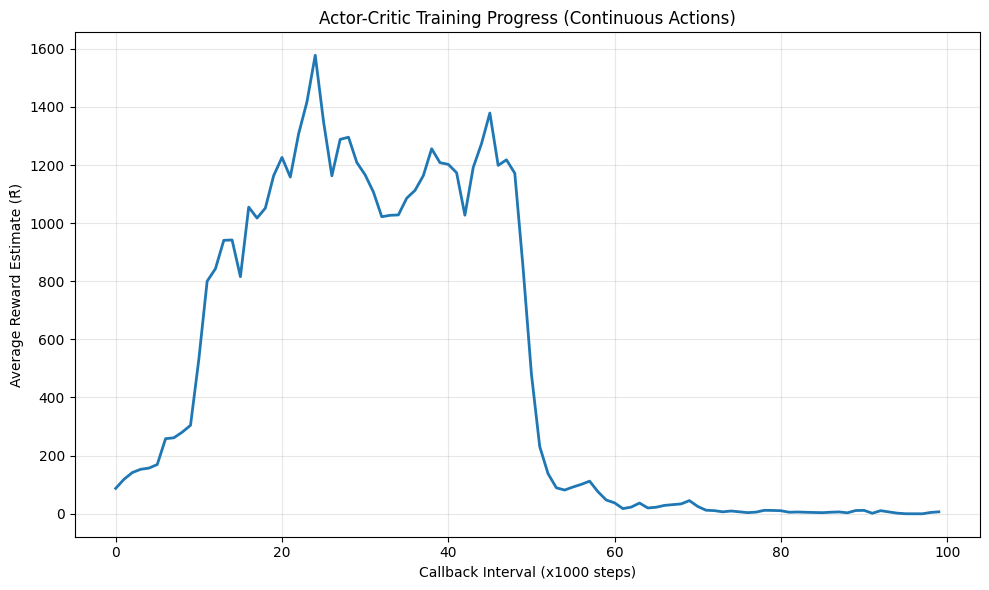

In [16]:
# ============================================================================
# Execution Script for Continuous Environment
# ============================================================================

import numpy as np
import matplotlib.pyplot as plt

# Setup environment settings
settings = {
    'b_max': 10.0,
    'c_max': 20.0,
    'p_max': 2.0,
    'w_cut_in': 3.0,
    'w_rated': 14.0,
    'w_cut_out': 25.0,
    'c_plus': 5.0,
    'c_minus': 10.0
}

# Setup environment - CONTINUOUS ENVIRONMENT
env = EnvEnergyCont(settings, seed=25328)

# Create approximators - USE GaussianPolicyTileCoding instead!
pi_hat = GaussianPolicyTileCoding(env, step_size=0.01, sigma=10.0, n_tilings=8, tiles_per_dim=8)
v_hat = ValueFunctionTileCoding(env, step_size=0.1, n_tilings=8, tiles_per_dim=8)

# Create trace dict to store results
trace = {'r_bar_history': [], 'rewards': []}

# Define callback function
def callback(pi_hat, info, trace):
    step = info['step']
    r_bar = info['avg_reward_estimate']
    avg_every = info['avg_reward_every']
    # Store history
    trace['r_bar_history'].append(r_bar)
    # Print progress
    print(f"\nStep {step:6d} | R̄={r_bar:7.2f} | Avg(window)={avg_every:7.2f}")

# Train using actor-critic
print("="*70)
print("Training with Continuous Environment (EnvEnergyCont)")
print("="*70)

actor_critic_continuing(
    pi_hat=pi_hat,
    v_hat=v_hat,
    steps=100000,
    alpha_r=0.001,
    r_bar_ini=0.0,
    callback=callback,
    callback_every=1000,
    trace=trace
)

# Evaluate learned policy
print("\nEvaluating learned policy...")
avg_reward, std_reward = evaluate_policy(pi_hat, n_steps=10000)
print(f"Evaluation: {avg_reward:.2f} ± {std_reward:.2f} EUR/hour")

# Plot results
if trace['r_bar_history']:
    fig = plot_results(trace)
    plt.savefig('/mnt/user-data/outputs/actor_critic_results_cont.png', dpi=150)
    print("Plot saved!")
    plt.show()